## Data Visualization

This script illustrates how to load and visualize the data.

In [4]:
import numpy as np
import importlib
import fncs
import matplotlib.pyplot as plt

importlib.reload(fncs)

<module 'fncs' from '/Users/briancpark/dev/school/csc542/proj/competition/src/fncs.py'>

Loading the data.

In [5]:
dataFolder = dirTrain = "../data/Train/"
xt, xv, yt, yv = fncs.loadTrial(dataFolder, id=1)

Plotting the measurements and labels.

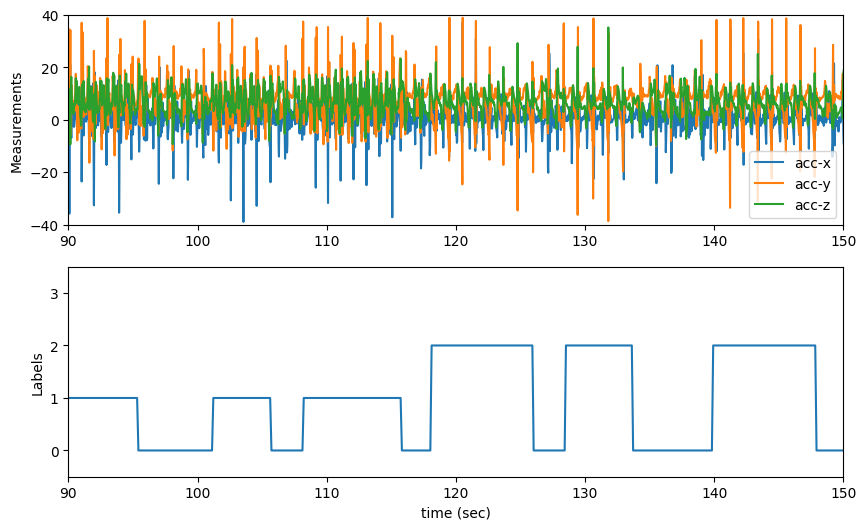

Labels include the following Locomotion Modes:
(0) Standing / Walking Hard Terrain
(1) Climbing Down Stairs
(2) Climbing Up Stairs
(3) Walking Soft Terrain


In [7]:
# Specifying a window of time for display
t_min = 90
t_max = 150

# Plotting the data
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(10, 6)

ax1.plot(xt, xv[:, 0:3])
ax1.axis([t_min, t_max, -40, 40])
ax1.set_ylabel("Measurements")
ax1.legend(["acc-x", "acc-y", "acc-z"])

ax2.plot(yt, yv)
ax2.axis([t_min, t_max, -0.5, 3.5])
ax2.set_xlabel("time (sec)")
ax2.set_ylabel("Labels")

plt.show()

# Displaying the labels
print("Labels include the following Locomotion Modes:")
print("(0) Standing / Walking Hard Terrain")
print("(1) Climbing Down Stairs")
print("(2) Climbing Up Stairs")
print("(3) Walking Soft Terrain")

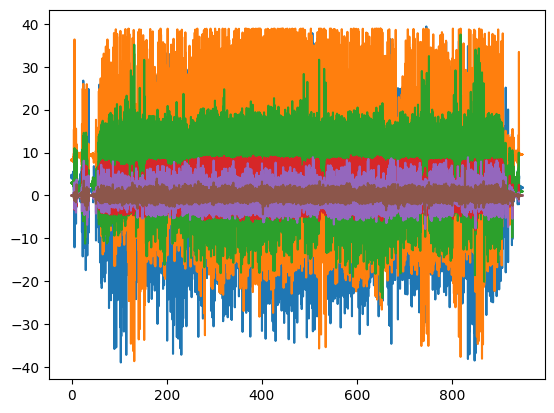

In [8]:
plt.plot(xt, xv)

In [9]:
xt.shape, yt.shape

((37890,), (9473,))

In [10]:
yt.shape[0] / xt.shape[0]

0.25001319609395617

In [11]:
dataFolder = dirTrain = "../data/Train/"
xt, xv, yt, yv = fncs.loadTrial(dataFolder, id=1)

In [12]:
# xt is recorded in 40hz, round xt to make sure they are in 40hz intervals

In [13]:
xt

array([0.00000e+00, 2.50000e-02, 5.00000e-02, ..., 9.47175e+02,
       9.47200e+02, 9.47225e+02])

In [14]:
yt[:10]

array([0.02, 0.12, 0.22, 0.32, 0.42, 0.52, 0.62, 0.72, 0.82, 0.92])

In [15]:
import pandas as pd

In [16]:
# def load_trial_df(data_folder, id):
id = 1

ids = list(range(1, 30))
df = pd.DataFrame()
for i in ids:

    x = np.genfromtxt("{}Trial{:02d}_x.csv".format(dataFolder, id), delimiter=",")
    df_x = pd.DataFrame(
        x, columns=["time", "acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]
    )
    y = np.genfromtxt("{}Trial{:02d}_y.csv".format(dataFolder, id), delimiter=",")
    df_y = pd.DataFrame(y, columns=["time", "label"])
    # if first entry  df_x isn't 0, realign time to start at 0
    df_x["time"] = df_x["time"] - df_x["time"][0]
    df_y["time"] = df_y["time"] - df_y["time"][0]

    # df_y is recorded in 10hz. Upsample each row to 40hz and fill in the interval, also replace the original time column
    df_y = df_y.reindex(df_x["time"], method="ffill")

    # remove index and set it as a column
    df_y.drop(columns="time", inplace=True)
    df_y.reset_index(inplace=True)
    df_y

    # merge based on time
    df_ = pd.merge(df_x, df_y, on="time")
    # print any nans or infs
    df = pd.concat([df, df_])
df

,time,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,label
0,0.000,4.435275,8.196063,2.974488,0.014215,-0.039157,-0.016744,0.0
1,0.025,4.186920,8.344455,2.908057,0.005771,-0.004480,-0.003345,0.0
2,0.050,4.544637,8.408659,2.890000,0.007967,0.022412,0.001159,0.0
3,0.075,4.849308,8.411614,2.900692,0.027778,-0.010670,-0.014223,0.0
4,0.100,4.509190,8.118649,2.847298,0.021577,-0.045498,-0.021111,0.0
...,...,...,...,...,...,...,...,...
37885,947.125,1.927349,9.584698,0.940000,-0.001852,0.015182,-0.000370,1.0
37886,947.150,1.930000,9.562658,0.874684,0.003927,0.006205,0.000671,1.0
37887,947.175,1.906144,9.555361,0.866144,-0.001111,-0.005937,-0.000032,1.0
37888,947.200,1.900380,9.575190,0.865570,-0.004195,-0.004688,-0.007653,1.0


In [17]:
# drop time
df.drop(columns="time", inplace=True)

In [18]:
# cast values to fp32
df = df.astype(np.float32)

In [38]:
# split train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns="label"), df["label"], test_size=0.2, random_state=42
)

In [46]:
# create a simple neural network in pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# use gpu if available
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)
device = "cpu"

print("device:", device)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X.iloc[idx].values, self.y.iloc[idx]

device: cpu


In [47]:
epochs = 10
# set up the model and training looop
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        labels = labels.long()  # convert labels to Long
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


print("Finished Training")

[1,  2000] loss: 0.354
[1,  4000] loss: 0.334
[1,  6000] loss: 0.333
[1,  8000] loss: 0.328
[1, 10000] loss: 0.325
[1, 12000] loss: 0.324
[1, 14000] loss: 0.324
[1, 16000] loss: 0.321
[1, 18000] loss: 0.320
[1, 20000] loss: 0.320
[1, 22000] loss: 0.319
[1, 24000] loss: 0.318
[1, 26000] loss: 0.315
[2,  2000] loss: 0.312
[2,  4000] loss: 0.314
[2,  6000] loss: 0.311
[2,  8000] loss: 0.312
[2, 10000] loss: 0.308
[2, 12000] loss: 0.308
[2, 14000] loss: 0.311
[2, 16000] loss: 0.307
[2, 18000] loss: 0.311
[2, 20000] loss: 0.308
[2, 22000] loss: 0.310
[2, 24000] loss: 0.307
[2, 26000] loss: 0.309
[3,  2000] loss: 0.306
[3,  4000] loss: 0.304
[3,  6000] loss: 0.301
[3,  8000] loss: 0.309
[3, 10000] loss: 0.306
[3, 12000] loss: 0.303
[3, 14000] loss: 0.303
[3, 16000] loss: 0.306
[3, 18000] loss: 0.300
[3, 20000] loss: 0.299
[3, 22000] loss: 0.305
[3, 24000] loss: 0.303
[3, 26000] loss: 0.301
[4,  2000] loss: 0.302
[4,  4000] loss: 0.298
[4,  6000] loss: 0.300
[4,  8000] loss: 0.299
[4, 10000] 

In [48]:
# run inference and get accuracy
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of the network on the test data: %d %%" % (100 * correct / total))

Accuracy of the network on the test data: 90 %


In [49]:
# alos the training accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of the network on the train data: %d %%" % (100 * correct / total))

Accuracy of the network on the train data: 90 %
